[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Overplanting within the PECD

This notebook provides a practical introduction on how to handle the conversion from capacity factor to generation data and vice-verse, in particular for solar photovoltaics (SPV), and its impact to the handling of the Pan-European Climate Database version 4.2 ([PECDv4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) data. This is particularly relevant considering that a capacity factor for SPV can be normalized by either the modules or inverter nominal capacity, for which the ratio - designated as oveprlanting, or inverter loading ratio - is quite dynamic and context-dependent.

**The tutorial will demonstrate how overplanting impacts the analysis and processing of installed capacity (IC) and capacity factor (CF) data (and could equally affect generation measurements)**. By clarifying some IC-related elements, it can also contribute to a clearer and more objective interaction with ENTSO-E's data collection for the Pan-European Market Modelling Database (PEMMDB).

For illustration purposes, this notebook uses a short temporal subsample of the PECDv4.2 dataset. This approach is intended to demonstrate the workflow and methodology rather than to produce robust, policy-relevant impact assessments.
It is important to emphasize that for rigorous climate impact studies, the use of such limited data is not sufficient. Reliable analyses should be based on longer time series (typically at least 30 years).  
In this example, we will download and read aggregated NUTS 2 data in CSV format for utility-scale fixed PV in 2020 / historical stream. In principle, this workflow can be extended to include multiple years, climate projection periods (2015–2100), and other energy technologies.

## Learning objectives 🧠

In this notebook, you will learn about overplanting and its trends. You will also understand how a misuse of IC data can impact your data analysis. Finally, you will see how to properly process your PECDv4.2 CF data.

## Target Audience 🎯

**Anyone** interested in learning about overplanting and how to deal with relevant PECDv4.2 data.

## Some theory first 📖

### SPV installed capacity (IC)


Solar photovoltaics generates its electricity in direct current (DC) and needs an inverter to work as an interface with the grid connection point. In practice, a SPV project is fully characterized by three installed capacities: i) the modules capacity for the DC side; ii) the inverter capacity for its AC output; and iii) the injection capacity of the grid connection point.

Thus, while the DC capacity drives SPV generation overall, the lowest of the AC values defines the maximum grid injection.

![pvcap_plot](img/overplanting/pvcap_plot.png)

### Overplanting and computing Capacity Factors 

Overplanting, also known as inverter loading, consists of an engineering design strategy where the IC of the PV modules (DC) intentionally surpass by a given margin its AC-counterpart. Traditionally, this has a financial motivation, e.g. a proportionally smaller inverter will be cheaper, but more and more it is being considered in local grid regulations. At the cost of some clipping, with the inverter saturating its output power whenever the DC output exceeds the nominal AC rate, developers can increase the overall revenue and/or have their projects be grid-compliant.

![overplanting_plot](img/overplanting/overplanting_plot.png)

Example of overplanting and resulting inverter saturation whenever the DC output surpasses the inverter nominal capacity.

Being CF calculated using the equation below, **it is important to discuss about which IC to consider**. 

$$ CF_{PV} =\frac{PV power}{IC}  $$


> **Note on SPV capacity factor (CF) within PECD**  
>PECD3.1 calculated CF using the $IC_{AC}$ with a constant 1.1 overplanting factor. Since PECDv4.1, we use instead the $IC_{DC}$, asking end-users for custom overplanting factors. This allows for the assumptions on overplanting to be made ad-hoc and a-posteriori using simple postprocessing, as well as helps highlight the need to consider properly the IC used.

## Prepare your environment

### Import libraries

In the following we will import five libraries: the [os](https://docs.python.org/3/library/os.html) module provides functions to interact with the operating system, especially for file and directory operations. It allows the script to build portable file paths, list contents of folders, or check if files exist. The [pandas](https://pandas.pydata.org/docs/) module provides a way to read, handle, and visualize tabular data; the [numpy](https://numpy.org/doc/stable) module is here used to generate sequence of float values; and the [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module allows us to generate and edit standard visualizations. [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) is a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing you to download the needed data for this work.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example, we use data from PECD version “PECD4.2” for the “Historical” temporal stream, derived from ERA5 reanalysis. The selected variable is the “solar photovoltaic generation capacity factor”, retrieved for the year 2020 at "NUTS 2" spatial resolution (find more about NUTS on [Eurostat](https://ec.europa.eu/eurostat/web/nuts)) and covering the photovoltaic technology "62 (SPV utility-scale fixed)", i.e. large, ground-based installations with fixed Si modules.

The API request reflecting these selections is shown in the next cell.

In [2]:
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "technology": ["62"],
    "spatial_resolution": ["nuts_2"],
    "year": ["2020"],
    "variable": ["solar_photovoltaic_generation_capacity_factor"],
}

Next, we will create a dedicated folder to store our data, call the retrieve method and unzip the downloaded data to be ready to use our CSV file.

In [ ]:
# create folder
input_dir = "cds_data/overplanting/"
os.system(f"mkdir -p {input_dir}")

# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/overplanting_data.zip")

# Unzipping every file in our folder
zip_path = os.path.join(input_dir, "overplanting_data.zip")
os.system(f"unzip {zip_path} -d {input_dir}")

## Read PECD NUTS 2-level capacity factor

Now we can read our data and print them to inspect their structure. As an example, We choose to see the DataFrame's columns of the following regions: Lazio (IT), Île-de-France (FR), Lisboa (PT), Berlin (DE) and Murcia (SP).

In [ ]:
# spv_utility_fix, 2020 (as an example)
filename = (
    "H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_"
    "S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_"
    "62_NA---_NA---_PhM03_PECD4.2_fv1.csv"
)

capacity_factors = pd.read_csv(
    input_dir + filename, comment="#", delimiter=",", index_col=["Date"], parse_dates=["Date"]
)
# respectively Lazio, Île-de-France, Lisboa, Berlin, Murcia
reg_list = ["ITI4", "FR10", "PT17", "DE30", "ES62"]
capacity_factors[reg_list].head(8)

ITI4  FR10  PT17  DE30  ES62
Date                                               
2020-01-01 00:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 01:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 02:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 03:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 04:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 05:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 06:00:00  0.0000   0.0   0.0   0.0   0.0
2020-01-01 07:00:00  0.0013   0.0   0.0   0.0   0.0

Let's inspect our data choosing Spain as an arbitrary sunny example.

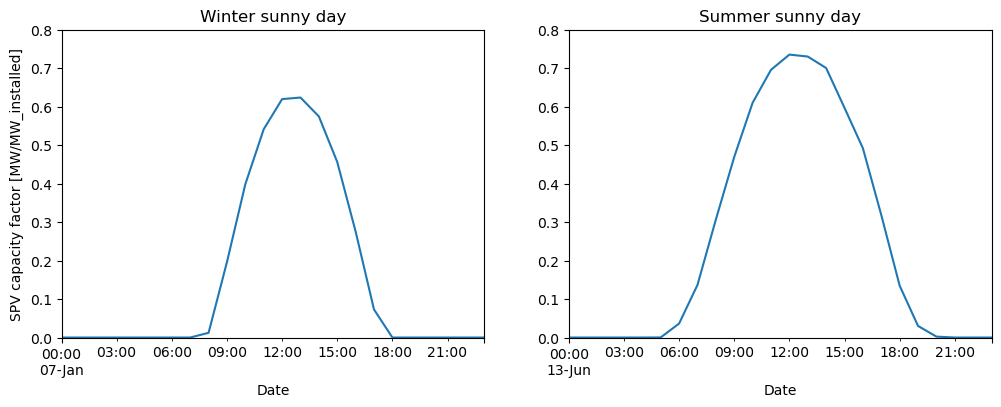

In [5]:
region_to_plot = "ES62"  # Murcia, south of Spain, as an example (sunny location)
sel_cf = capacity_factors[region_to_plot]

# plotting side by side a winter and a summer day
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sel_cf["2020-01-07"].plot(ax=ax1)
sel_cf["2020-06-13"].plot(ax=ax2)

ax1.set_title("Winter sunny day")
ax1.set_ylabel("SPV capacity factor [MW/MW_installed]")
ax1.set_ylim([0, 0.8])
ax2.set_title("Summer sunny day")
ax2.set_ylim([0, 0.8])

plt.show()

## Converting capacity factor to generation (CF units and IC data)

As you can see in the units of the y-axis in the left plot above, the SPV capacity factor is computed in MW/MW_installed. As mentioned before, **PECDv4.1 and v4.2 compute $CF_{PV}$ considering the $IC_{DC}$ (i.e. the "MW_installed" refers to the modules)**.

Therefore, converting between capacity factor and PV generation **using directly the $IC_{AC}$ can lead to unintentional deviations**.

Let's imagine a situation, where a TSO only has access to AC-level IC data, totalling 1 GW. In a situation where the majority of this capacity refers to utility-scale plants, an overplanting of 1.35 would be an acceptable assumption (check section "Contextual information on overplanting" below).

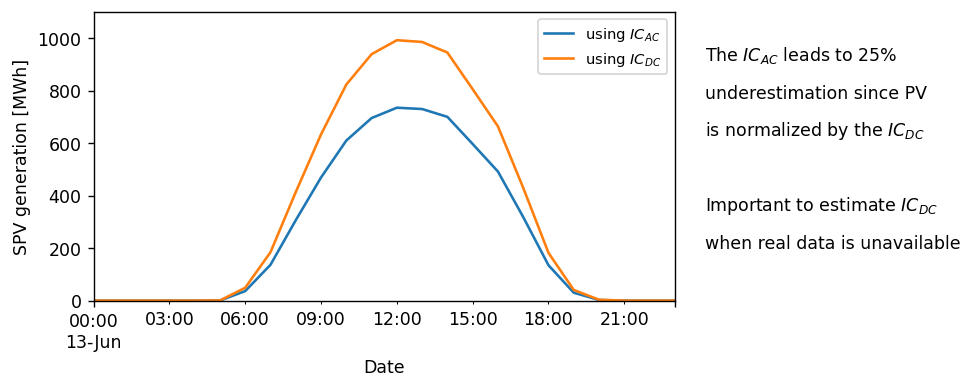

In [6]:
overplanting = 1.35
ic_ac = 1000  # installed capacity, 1 GW as example
ic_dc = ic_ac * overplanting  # GWp, peak DC module capacity

fig, ax1 = plt.subplots(1, 1, figsize=(6, 3), dpi=125)
(sel_cf["2020-06-13"] * ic_ac).plot(ax=ax1)
(sel_cf["2020-06-13"] * ic_dc).plot(ax=ax1)
ax1.set_ylim([0, 1100])
ax1.set_ylabel("SPV generation [MWh]")
ax1.legend(["using $IC_{}$".format("{AC}"), "using $IC_{}$".format("{DC}")], fontsize=8.5)

underestimate = int((1 - 1 / overplanting) * 100)
textstr = [
    "The $IC_{}$ leads to {}%".format("{AC}", underestimate),
    "underestimation since PV",
    "is normalized by the $IC_{}$".format("{DC}"),
]
for k in range(0, 3):
    plt.text(0.94, 0.75 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = ["Important to estimate $IC_{}$".format("{DC}"), "when real data is unavailable"]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

**When only $IC_{AC}$ is available, it is crucial to estimate the corresponding $IC_{DC}$**. For PECDv4.2, **we propose the following values** (c.f. section "Contextual information" below):
- residential rooftop: 1.05-1.1
- industrial rooftop: 1.15-1.2
- utility fixed and tracking: 1.2-1.35

Conversely, **if you normalize generation data** using the $IC_{AC}$, you will be overestimating your data since it will not match with the convention assumed within PECD SPV data.

## Accounting for clipping losses

### A first, not-so-successful example

We now need to take account for inverter saturation (also known as clipping losses). In essence, the PV output is capped whenever its DC output surpasses the inverter AC nominal rate.

From a CF perspective, the effective output can never surpass `AC/DC ratio`, which is the inverse of the overplanting factor.

$$ CF' = min(CF,\frac{IC_{AC}}{IC_{DC}}) = min(CF,\frac{1}{\frac{IC_{DC}}{IC_{AC}}})$$

Picking on the previous example, an overplanting of 1.35 means that the effective SPV CF can never surpass 0.74 (1/1.35).

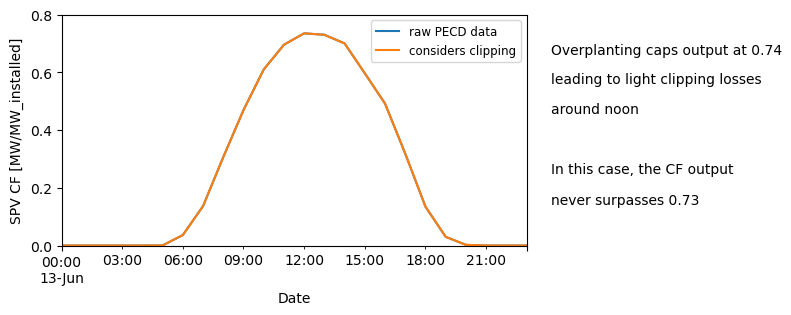

In [7]:
# Using pandas, we can use the clip() functions that defines the min and
# max values for the dataframe
clipped_sel_cf = sel_cf.clip(0, 1 / overplanting)

ax1 = sel_cf["2020-06-13"].plot(figsize=(6, 3))
clipped_sel_cf["2020-06-13"].plot()

ax1.set_ylim([0, 0.8])
ax1.set_yticks(np.arange(0, 1, 0.2))
ax1.set_ylabel("SPV CF [MW/MW_installed]")
ax1.legend(["raw PECD data", "considers clipping"], fontsize=8.5)

value = round(1 / overplanting, 2)
textstr = [
    "Overplanting caps output at {}".format(value),
    "leading to light clipping losses",
    "around noon",
]
for k in range(0, 3):
    plt.text(0.94, 0.75 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = [
    "In this case, the CF output",
    "never surpasses {}".format(sel_cf["2020-06-13"].round(2).max()),
]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

The fact that no clipping is detected is likely related to how [hourly data underestimates clipping losses due to temporal smoothing](https://pubs.aip.org/aip/jrse/article/14/6/063503/2848734/The-effect-of-short-term-inverter-saturation-on), which can be amplified by ERA5's coarser resolution (even more if spatially aggregated) and its [slight underestimation of solar resource under clear-sky conditions](https://www.sciencedirect.com/science/article/pii/S0038092X18301920). Thus, we suggest that this processing is done ideally using gridded data before further aggregating in space. A future release of PECD may account for the underestimation due to the temporal averaging.

### A second example

Since the overplanting assumed above was too low for us to see clipping actually taking place, we will now assume a considerably  higher, although unrealistic, overplanting of 2 for the sake of illustration (i.e., the effective SPV capacity factor upper boundary is limited by the inverter to 0.5).
We assume a much higher overplanting of 2 where the effective SPV CF can never surpass 0.5 (1/2).

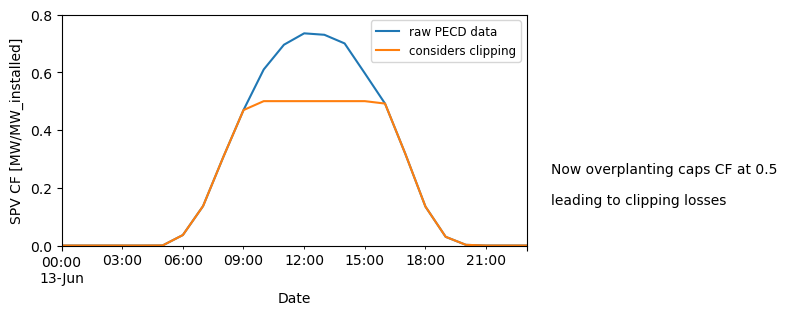

In [8]:
overplanting2 = 2
ic_dc = ic_ac * overplanting2  # GWp, peak DC module capacity

# Using pandas, we can use the clip() functions that defines the min and
# max values for the dataframe
clipped_sel_cf = sel_cf.clip(0, 1 / overplanting2)

ax1 = sel_cf["2020-06-13"].plot(figsize=(6, 3))
clipped_sel_cf["2020-06-13"].plot()

ax1.set_ylim([0, 0.8])
ax1.set_yticks(np.arange(0, 1, 0.2))
ax1.set_ylabel("SPV CF [MW/MW_installed]")
ax1.legend(["raw PECD data", "considers clipping"], fontsize=8.5)

value = round(1 / overplanting2, 2)
textstr = ["Now overplanting caps CF at {}".format(value), "leading to clipping losses"]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

Now, let's estimate SPV generation in the absence/presence of inverter clipping:

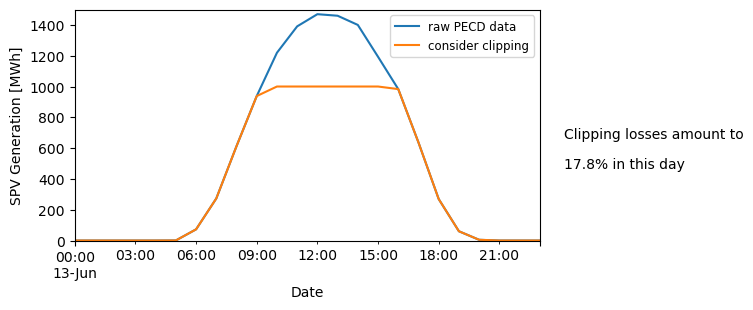

In [9]:
# When we look at this from an energy perspective
ax1 = (sel_cf["2020-06-13"] * ic_dc).plot(figsize=(6, 3))
(clipped_sel_cf["2020-06-13"] * ic_dc).plot()

ax1.set_ylim([0, 1500])
ax1.set_ylabel("SPV Generation [MWh]")
ax1.legend(["raw PECD data", "consider clipping"], fontsize=8.5)

temp = (clipped_sel_cf["2020-06-13"] * ic_dc).sum() / (sel_cf["2020-06-13"] * ic_dc).sum()
loss = ((1 - temp) * 100).round(1)
textstr = ["Clipping losses amount to", "{}% in this day".format(loss)]
for k in range(0, 2):
    plt.text(0.94, 0.45 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

### Proposing some more structured code to process data

Up to now, the focus was more on understanding and illustrating clipping, following a storytelling format. However, for your day-to-day work, you can benefit from having a set of structured functions that:
- Apply clipping to PECD capacity-factor (CF) time series when needed.
- Convert CF to energy (MWh) under different capacity information setups.
- Convert measured energy back to CF for comparison with PECD.

The final plot illustrates a representative daily PV generation profile with clipping applied, enabling a quick check that your chosen DC/AC configuration (or overplanting ratio) behaves as intended on real days.

In [ ]:
# add clipping (inverter saturation) to capacity factor timeseries sourced from PECD
# this can also be done within cf_to_energy below with "clipping" parameter True
def add_clipping_to_pecd_cf(cf_in, ic_dc=None, ic_ac=None, overplanting=None):
    # Count non-None inputs
    provided = [x is not None for x in (ic_dc, ic_ac, overplanting)].count(True)

    if provided != 2:
        raise ValueError(
            "You must provide exactly two of the three arguments: " "ic_dc, ic_ac, overplanting."
        )

    if (ic_dc is not None) & (ic_ac is not None):  # if both ICs are available
        cf_clip = cf_in.clip(0, ic_ac / ic_dc)

    if (ic_dc is None) | (ic_ac is None):  # if one of the ICs is unavailable
        cf_clip = cf_in.clip(0, 1 / overplanting)

    return cf_clip


# converting PECD CF data to PV generation in MWh
# the capacity factors provided as inputs may include, or not, clipping
# depends if user wants to  accounted for it in the resulting generation output


def cf_to_energy(cf_in, ic_dc=None, ic_ac=None, overplanting=None, dt_hour=1, clipping=True):
    # Count non-None inputs
    provided = [x is not None for x in (ic_dc, ic_ac, overplanting)].count(True)

    if provided != 2:
        raise ValueError(
            "You must provide exactly two of the three arguments: " "ic_dc, ic_ac, overplanting."
        )

    if ic_dc is None:
        if clipping is True:
            power_out = cf_in.clip(0, 1 / overplanting) * ic_ac * overplanting
        else:
            power_out = cf_in * ic_ac * overplanting

    elif ic_ac is None:
        if clipping is True:
            power_out = cf_in.clip(0, 1 / overplanting) * ic_dc
        else:
            power_out = cf_in * ic_dc
    else:
        if clipping is True:
            power_out = cf_in.clip(0, ic_ac / ic_dc) * ic_dc
        else:
            power_out = cf_in.clip * ic_dc

    ener_out = power_out * dt_hour
    return ener_out


# convert measured generation to CF for comparing with PECD
# the provided generation data should be hourly to match the resolution of the PECD


def energy_to_cf(ener_in, ic_dc=None, ic_ac=None, overplanting=None):
    # Count non-None inputs
    provided = [x is not None for x in (ic_dc, ic_ac, overplanting)].count(True)

    if provided != 2:
        raise ValueError(
            "You must provide exactly two of the three arguments: " "ic_dc, ic_ac, overplanting."
        )

    if ic_dc is None:
        cf_out = ener_in / (ic_ac * overplanting)
    elif ic_ac is None:
        cf_out = ener_in / ic_dc

    return cf_out

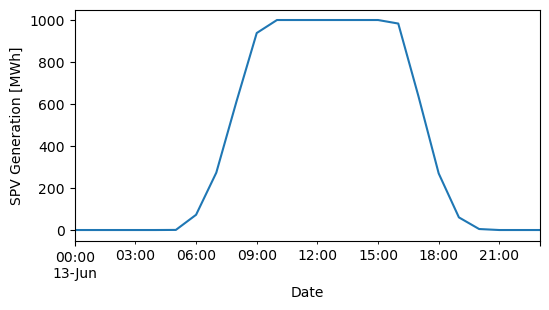

In [11]:
# examples of function being used (all produce same output)
sel_gen = cf_to_energy(sel_cf, ic_ac=1000, overplanting=2)
_ = cf_to_energy(sel_cf, ic_dc=2000, overplanting=2)
_ = cf_to_energy(sel_cf, ic_dc=2000, ic_ac=1000)

plt.figure()
ax = sel_gen["2020-06-13"].plot(figsize=(6, 3))
ax.set_ylabel("SPV Generation [MWh]")

plt.show()

## Contextual information on overplanting

Public databases containing both AC and DC IC at the individual installation level is not common, despite the high value it can provide for a better use of the PECD data.

In the figure below, we can see histograms of overplanting ratios for different installation sizes in the USA. There is a clear trend for larger installations to consider larger overplanting factors.

![overplanting_histogram](img/overplanting/overplanting_histogram.png)

Overplanting ratio as a function of installation size.
Data source: [Tracking The Sun Initiative, LBNL](https://emp.lbl.gov/tracking-the-sun)

This data supported our tentative value range, which we recap here:
- residential rooftop: 1.05-1.1
- industrial rooftop: 1.15-1.2
- utility fixed and tracking: 1.2-1.35

However, it is important to have in mind that overplanting practices depend on the engineering and grid practices, which change in time and space. For example, in the USA, there is a trend of an increasing overplanting when designing PV projects.

![overplanting_trends](img/overplanting/overplanting_trends.png)

Source: [U.S. Energy Information Administration (eia)](https://www.eia.gov/todayinenergy/detail.php?id=35372)

## Take home messages 📌

*  When handling PECD, it is really important to consider DC-level IC data. When such data is unavailable, an estimate is needed, otherwise there is a mismatchin when converting CF or generation data. Typical values are here provided.
*  Clipping losses also take place, although ERA5's native resolution is not ideal to fully account for this. This will be looked in more detail during the next service contract.
*  The degree of overplanting varies from generator to generator, however trends can be found for specific size ranges. However, these trends can change in time and space.
*  There is great value on TSOs collecting both AC and DC IC from generators.